### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов.

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом(вставить свой) - https://github.com/runnerup96/pytorch-machine-translation

Ноутбук с результатами выкладывать на ваш **google диск** курса.

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский.

In [1]:
!unzip /content/rus-eng.zip
!unzip /content/src.zip

Archive:  /content/rus-eng.zip
   creating: rus-eng/
  inflating: __MACOSX/._rus-eng      
  inflating: rus-eng/rus.txt         
  inflating: __MACOSX/rus-eng/._rus.txt  
  inflating: rus-eng/_about.txt      
  inflating: __MACOSX/rus-eng/.__about.txt  
Archive:  /content/src.zip
   creating: src/
  inflating: __MACOSX/._src          
  inflating: src/metrics.py          
  inflating: __MACOSX/src/._metrics.py  
  inflating: src/txt_logger.py       
  inflating: __MACOSX/src/._txt_logger.py  
   creating: src/models/
  inflating: __MACOSX/src/._models   
   creating: src/__pycache__/
  inflating: __MACOSX/src/.___pycache__  
   creating: src/data/
  inflating: __MACOSX/src/._data     
  inflating: src/models/attention.py  
  inflating: __MACOSX/src/models/._attention.py  
  inflating: src/models/seq2seq_t5.py  
  inflating: __MACOSX/src/models/._seq2seq_t5.py  
  inflating: src/models/__init__.py  
  inflating: __MACOSX/src/models/.___init__.py  
  inflating: src/models/encoder_rnn.py 

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов.

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой.
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [3]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 13.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [6]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [49]:
import torch.nn as nn
import torch

from src.data.datamodule import DataManager
from src.models.seq2seq_transformer import Seq2SeqTransformer
from src.models.trainer import Trainer
from src import metrics
from pytorch_lightning.loggers import WandbLogger

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [31]:
config = {
    'filename': 'rus-eng/rus.txt',
    'prefix_filter': None,
    'max_length': 15,
    'train_size': 0.8,
    'batch_size': 16,
    'epoch_num': 10,
    'device': 'cuda'
}

data_manager = DataManager(config, 'cuda')

In [34]:
train_dataloader, val_dataloader = data_manager.prepare_data()

Reading from file: 100%|██████████| 496059/496059 [00:09<00:00, 54804.33it/s]


In [15]:
train_dataloader.dataset[100000]

(tensor([   1,   44,   76,  126, 3662,   45,    2,    3,    3,    3,    3,    3,
            3,    3,    3], device='cuda:0'),
 tensor([   1,  140,  137,   65, 1730, 1576,    2,    3,    3,    3,    3,    3,
            3,    3,    3], device='cuda:0'))

In [35]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=config['device'])) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=config['device']).type(torch.bool)

    src_padding_mask = (src == 3).transpose(0, 1)
    tgt_padding_mask = (tgt == 3).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [36]:
model = Seq2SeqTransformer(
    num_encoder_layers = 2,
    num_decoder_layers = 2,
    emb_size = 128,
    nhead = 4,
    src_vocab_size = data_manager.source_tokenizer.tokenizer.get_vocab_size(),
    tgt_vocab_size = data_manager.target_tokenizer.tokenizer.get_vocab_size(),
    dim_feedforward = 512,
    dropout = 0.1
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [45]:
BOS_IDX = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 15

class Seq2SeqTrainer(nn.Module):
    def __init__(self, model, optimizer, scheduler, loss_fn, src_tokenizer, tgt_tokenizer):
        super(Seq2SeqTrainer, self).__init__()

        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_fn = loss_fn
        self.tgt_tokenizer = tgt_tokenizer
        self.src_tokenizer = src_tokenizer

        self.model.to(DEVICE)
        self.loss_fn.to(DEVICE)


    def training_step(self, batch):
        self.optimizer.zero_grad()
        src, tgt = batch
        src = src.transpose(1, 0).to(DEVICE)
        tgt = tgt.transpose(1, 0).to(DEVICE)
        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = self.model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
        tgt_out = tgt[1:, :]
        loss = self.loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        return loss

    def validation_step(self, batch):
        with torch.no_grad():
            src, tgt = batch
            src = src.transpose(1, 0)
            tgt = tgt.transpose(1, 0)
            tgt_input = tgt[:-1, :]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
            logits = self.model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            tgt_out = tgt[1:, :]
            loss = self.loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        return loss

    def forward(self, src):
        batch_size = src.shape[0]
        src = src.transpose(1, 0)
        tgt_input = torch.tensor([[BOS_IDX] * batch_size], dtype=torch.long, device=DEVICE).view(1, batch_size)
        for i in range(MAX_LEN):
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
            logits = self.model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            _, next_items = logits[-1].topk(1)
            next_items = next_items.squeeze().view(1, batch_size)
            tgt_input = torch.cat((tgt_input, next_items), dim=0)
        return tgt_input, None

    def eval_bleu(self, predicted_ids_list, target_tensor):
        predicted = predicted_ids_list.squeeze().detach().cpu().numpy().swapaxes(0, 1)[:, 1:]
        actuals = target_tensor.squeeze().detach().cpu().numpy()[:, 1:]
        bleu_score, actual_sentences, predicted_sentences = metrics.bleu_scorer(
            predicted=predicted, actual=actuals, target_tokenizer=self.tgt_tokenizer
        )
        return bleu_score, actual_sentences, predicted_sentences

In [20]:
!pip install torchtune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_pyt

In [21]:
from torchtune.utils.metric_logging import WandBLogger

logger = WandBLogger(
    project="DL sbt",
    group='HW3'
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [46]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.99)

model_trainer = Seq2SeqTrainer(model, optimizer, scheduler, loss_fn, data_manager.source_tokenizer, data_manager.target_tokenizer)

In [47]:
trainer_cls = Trainer(model=model_trainer, model_config=config, logger=logger)

In [50]:
trainer_cls.train(train_dataloader, val_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 10%|█         | 1/10 [05:13<46:59, 313.27s/it]

Current BLEU:  0.03430072725587665
мне нужно знать почему тома не было сегодня в школе ---> я знаю что том будет в бостоне
мы с томом написал и в со авто р стве несколько книг ---> я знаю что том в бостоне
может просто по си дишь там и послу ша ешь ---> ты не можешь это сделать
я не сказал тому что у меня нет прав ---> я не знаю что том не будет
похоже что это ужа сная потеря времени ---> это было очень хорошо
##############################


 20%|██        | 2/10 [10:30<42:03, 315.44s/it]

Current BLEU:  0.0
я думал ты по говоришь об этом с томом ---> я знаю что ты это сделал том
теперь мы не сможем до г на ть тома ---> том сказал что мэри будет
я не могу вспомнить когда в последний раз видел тебя таким счастливым ---> я не знаю что ты это сделал
что это за фильм популя р ный ---> что это было
том не считает эту проблему настолько серьёз ной ---> том сказал что мэри не будет это делать
##############################


 30%|███       | 3/10 [15:41<36:33, 313.40s/it]

Current BLEU:  0.01736011914908886
том научился водить когда ему было тринадцать ---> том хочет чтобы я это сделал
все слова под чёр к ну ты е крас ным должны быть про верен ---> он был в бостоне
думаешь том знает что случилось ---> том сказал что ты это сделал
слушай я уже сказал всё что тебе нужно знать ---> я знаю что ты не так
люди могли бы из бежать мно же ства ошибок прово дя про сты е ---> это было очень хорошо
##############################


 40%|████      | 4/10 [20:52<31:15, 312.61s/it]

Current BLEU:  0.0
не думаю что том знает с кем мэри ходи ла на концерт ---> я не знал что том это сделал
том сказал что он меня любит и хочет на мне жениться ---> том сказал что мэри не так ли
том спросил у меня нашёл ли я то что искал ---> я знаю что том это сделал
том не хотел делать ничего такого о чём бы потом пожал ел ---> том не хочет чтобы я это сделал
том подробно объяснил мэри как это делается ---> том знает что мэри
##############################


 40%|████      | 4/10 [24:01<36:02, 360.36s/it]


Last 4 epoch train loss:  tensor(22110.9297, device='cuda:0', grad_fn=<AddBackward0>)
Last 4 epoch val loss:  tensor(3.9362, device='cuda:0')
Last 4 epoch val bleu:  0.0


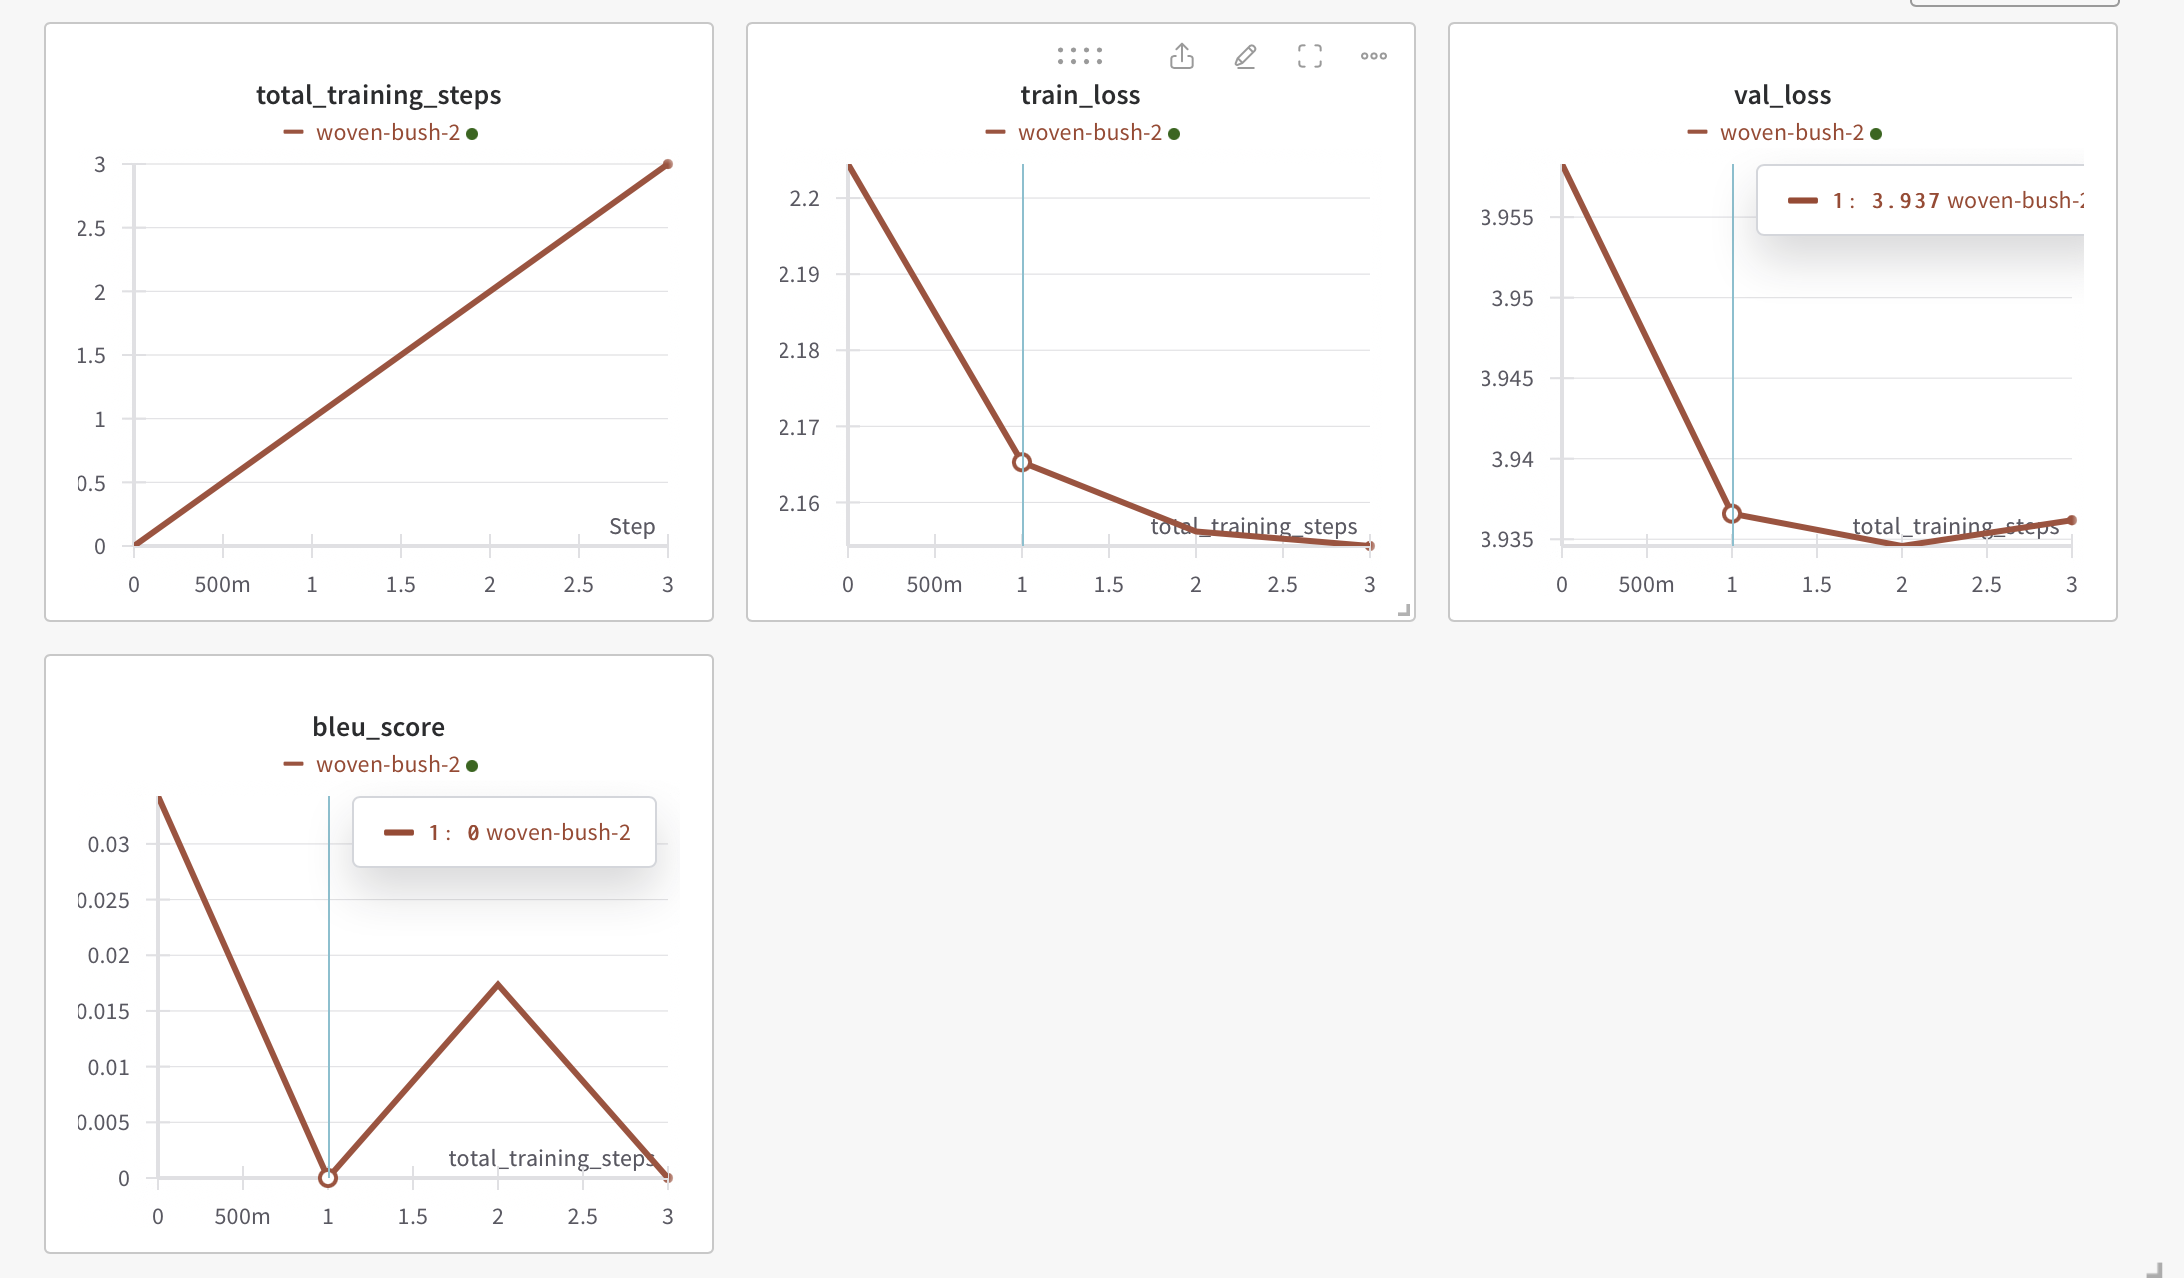

In [52]:
from IPython.display import Image
Image("/content/Снимок экрана 2024-05-27 в 22.02.32.png")

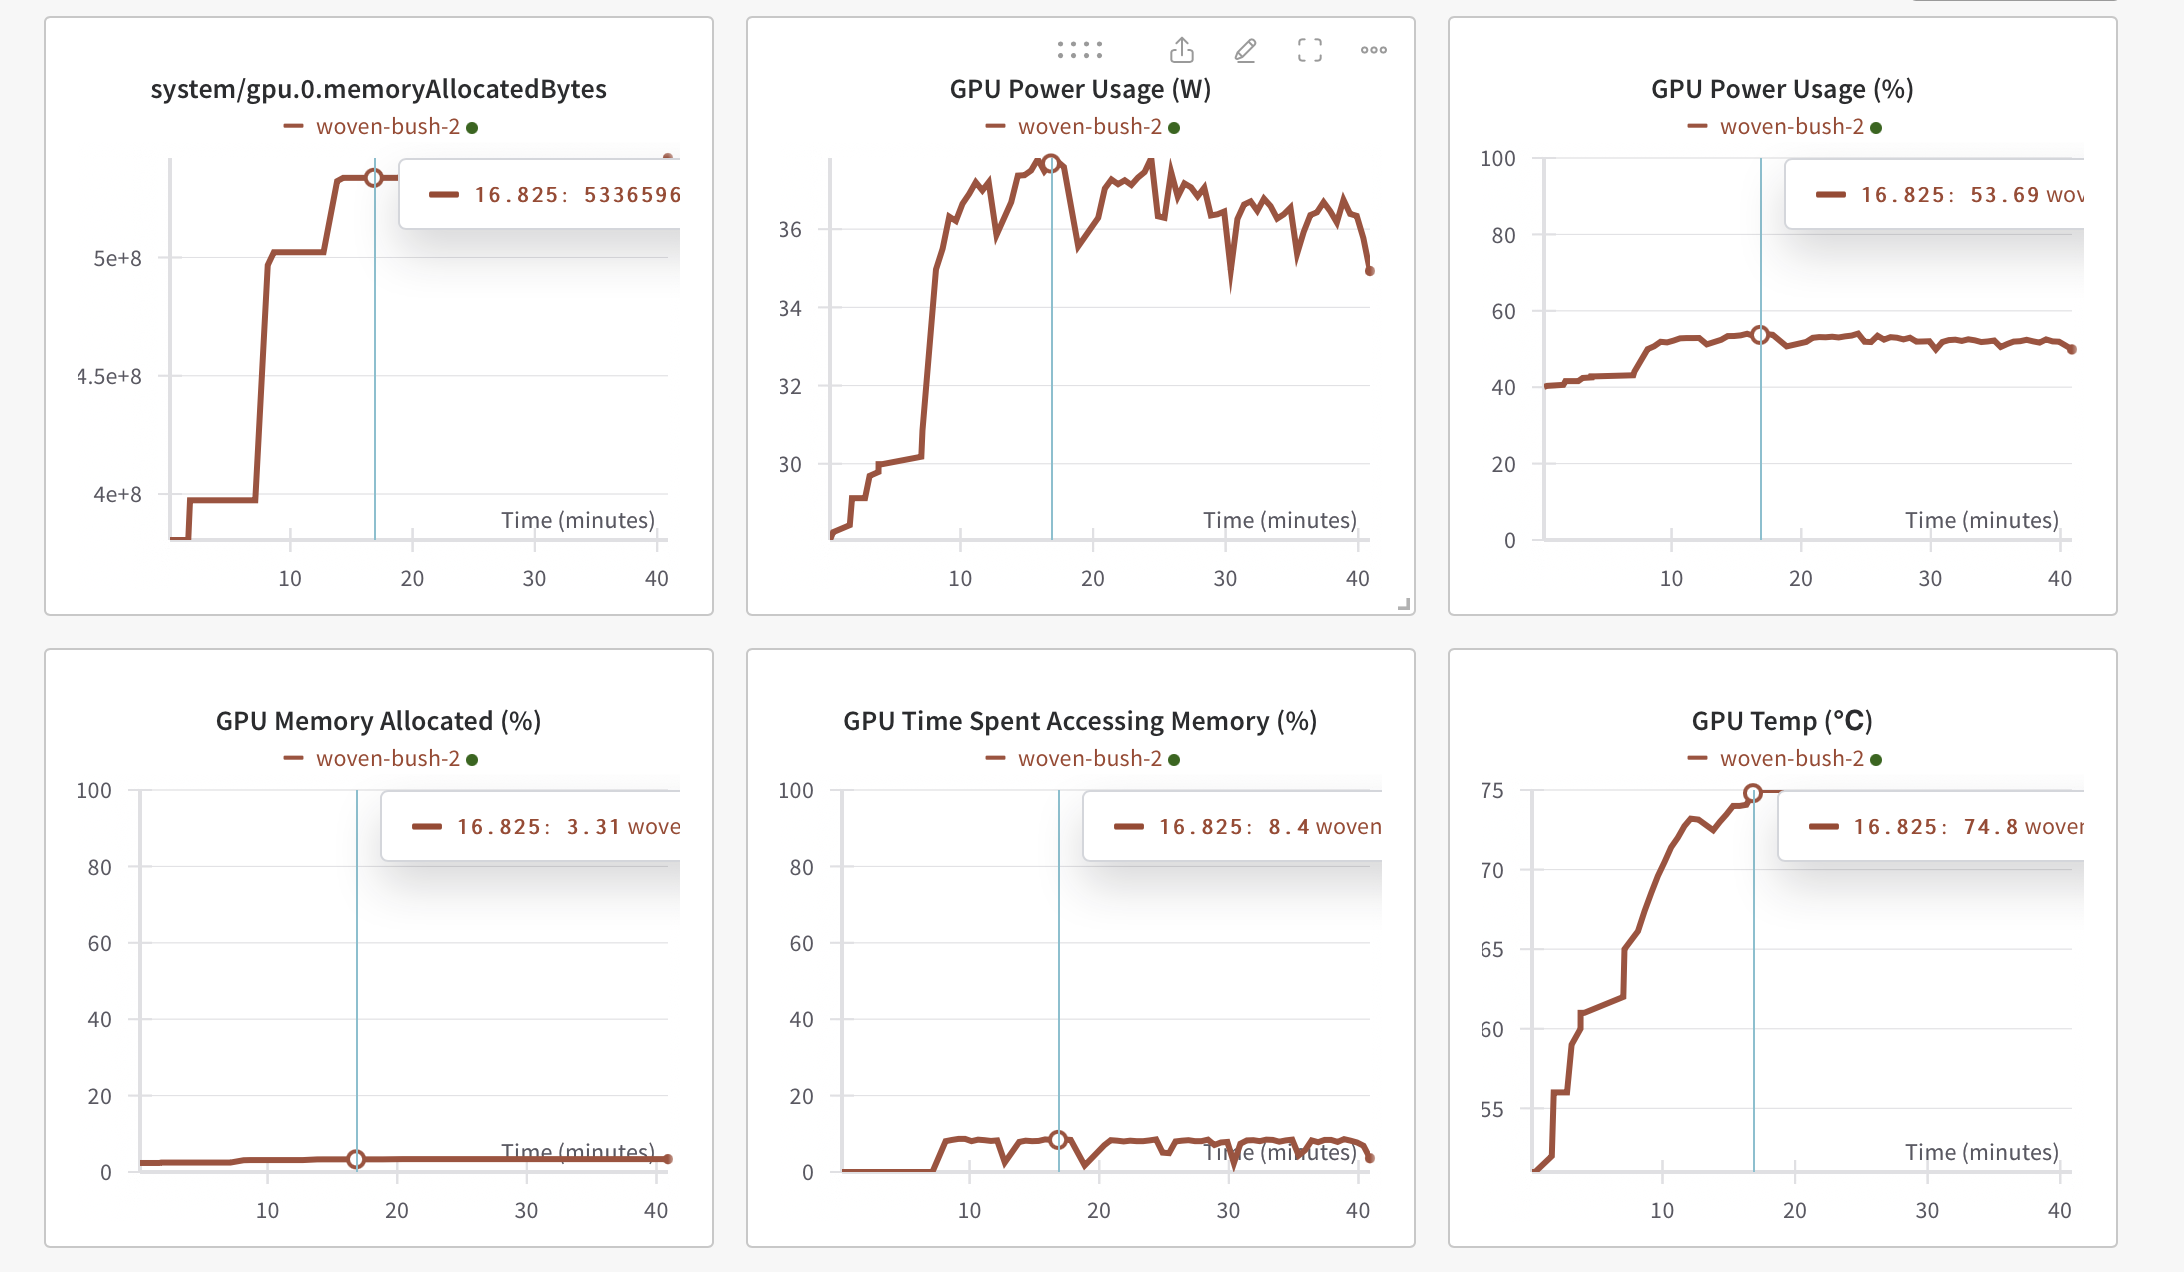

In [53]:
Image("/content/Снимок экрана 2024-05-27 в 22.02.50.png")

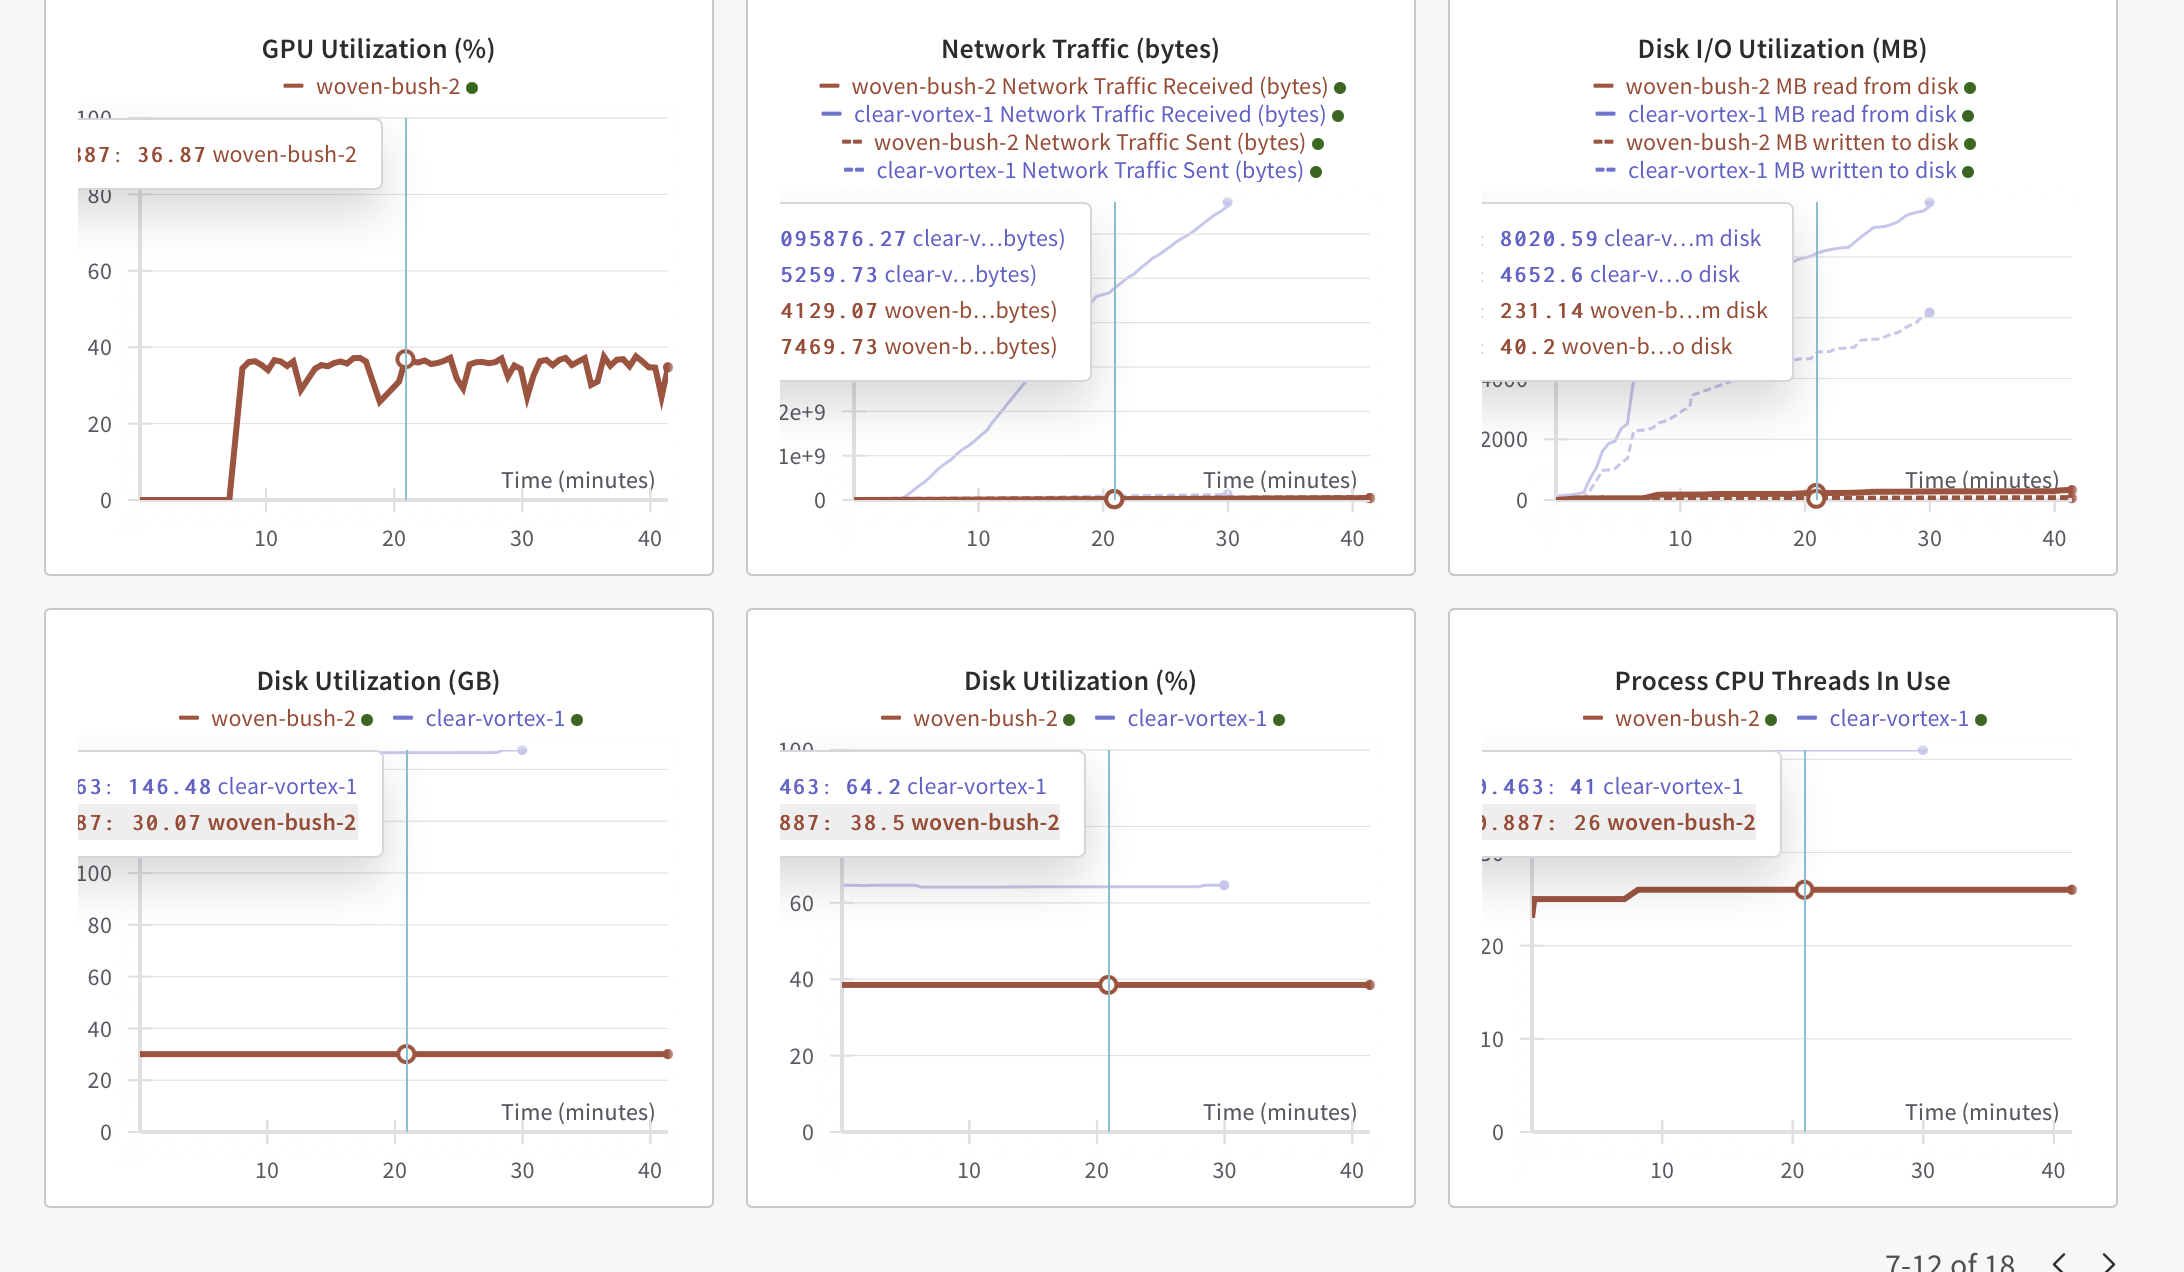

In [54]:
Image("/content/Снимок экрана 2024-05-27 в 22.03.14.png")

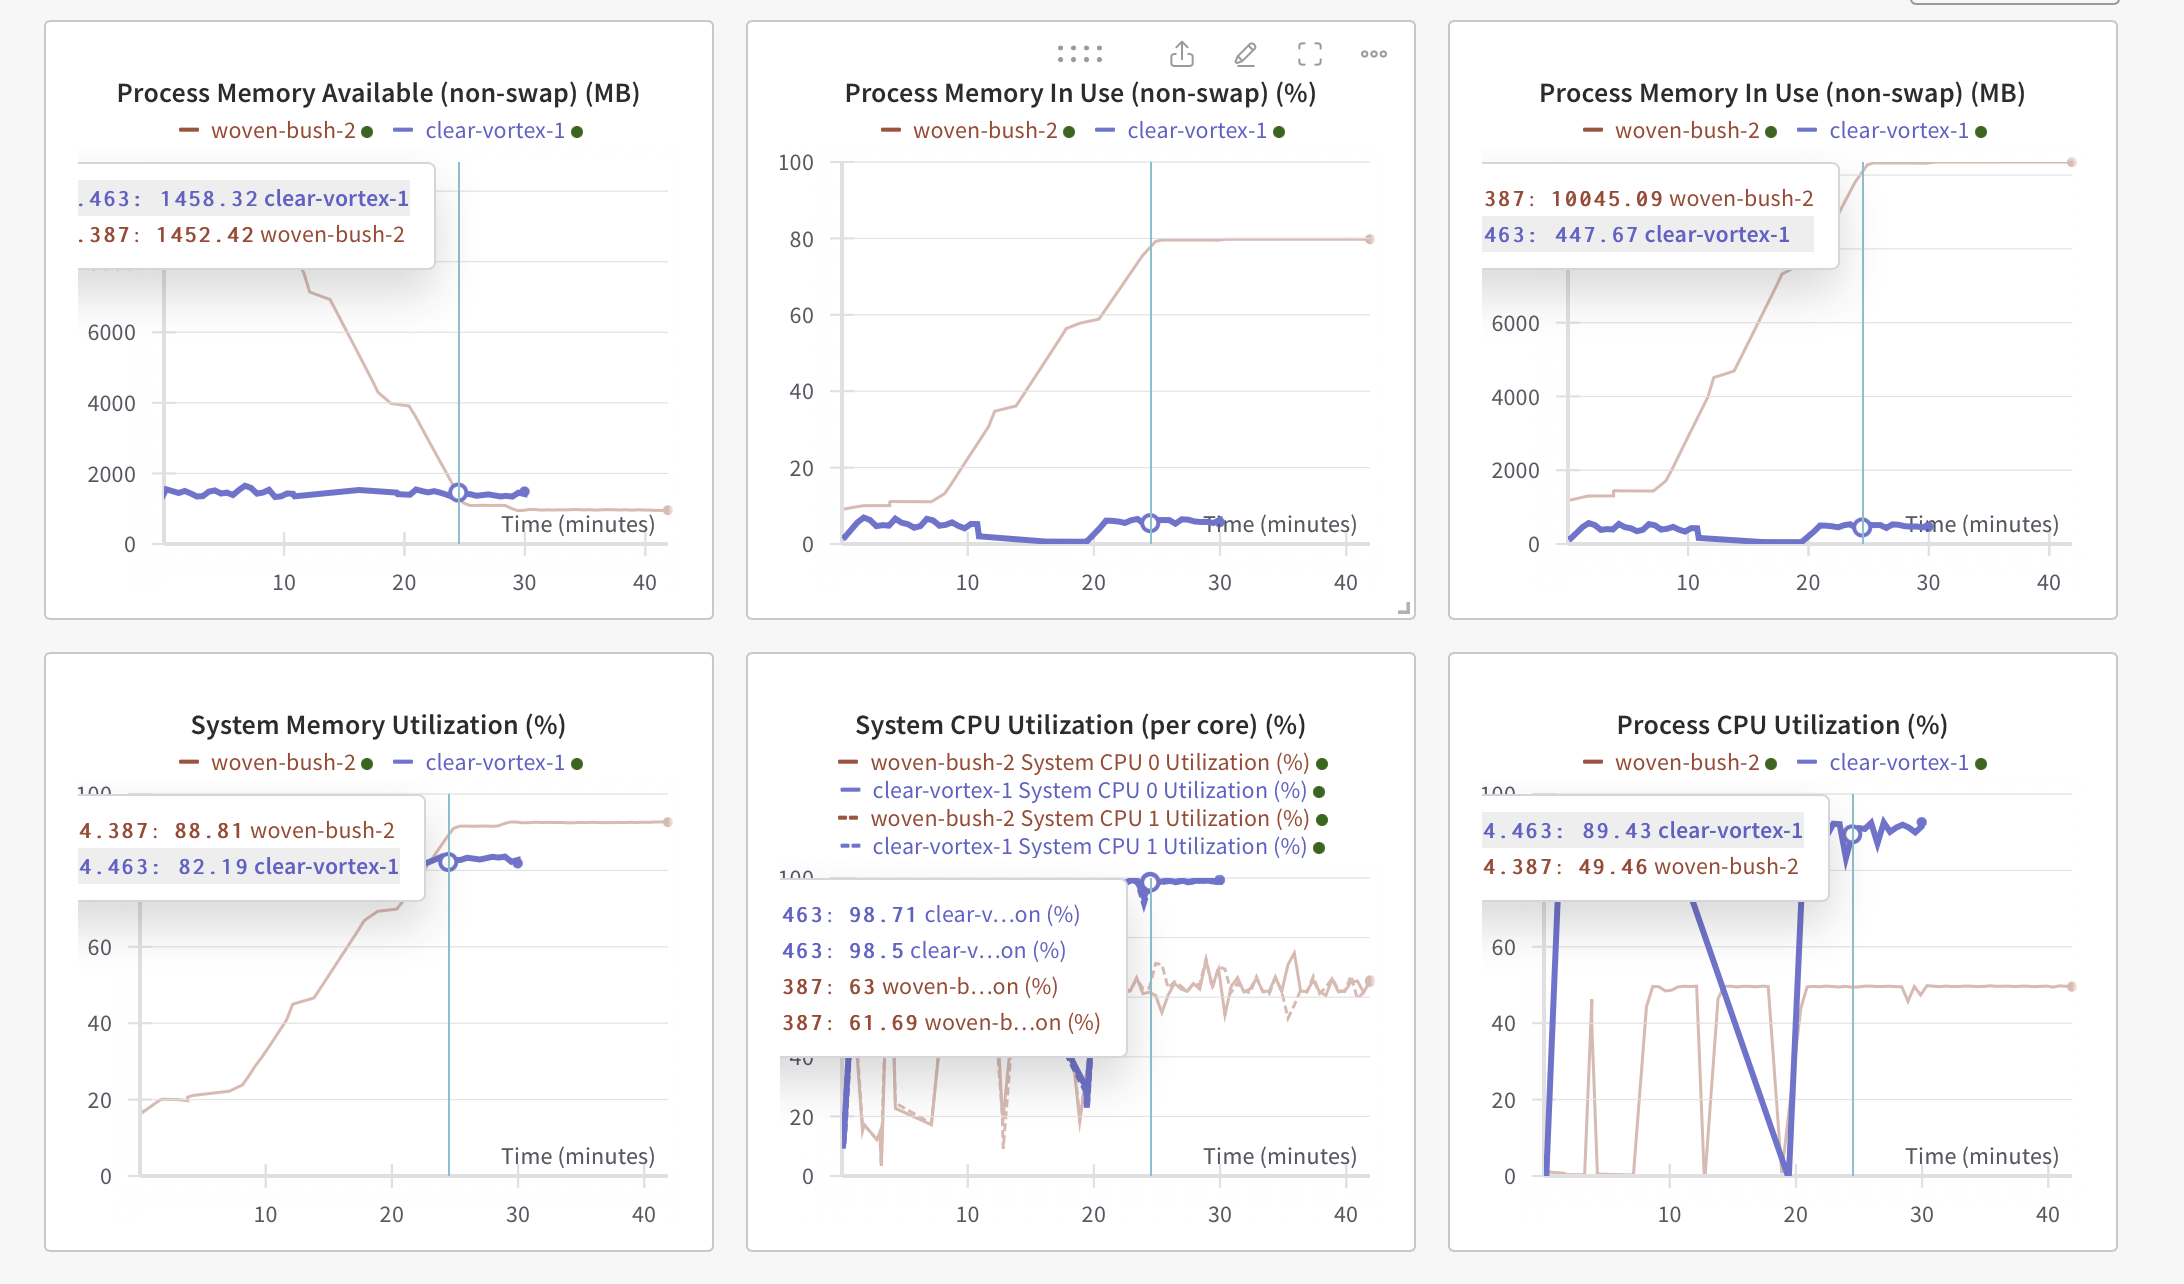

In [55]:
Image("/content/Снимок экрана 2024-05-27 в 22.03.35.png")

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [56]:
from transformers import T5ForConditionalGeneration

In [66]:
from transformers import T5Tokenizer

In [80]:
BATCH_SIZE = 16
RANDOM_STATE = 456
MAX_LEN = 15
LEARNING_RATE = 0.001
SHEDULER_STEP_SIZE = 1000
EPOCH_NUM = 5
PREFIX_FILTER = None
TRY_ONE_BATCH = False
FILENAME = 'rus-eng/rus.txt'
TRAIN_SIZE = 0.8

config = dict()
config['batch_size'] = BATCH_SIZE
config['prefix_filter'] = PREFIX_FILTER
config['max_length'] = MAX_LEN
config['epoch_num'] = EPOCH_NUM
config['try_one_batch'] = TRY_ONE_BATCH
config['learning_rate'] = LEARNING_RATE
config['device'] = DEVICE
config['filename'] = FILENAME
config['train_size'] = TRAIN_SIZE

dm = DataManager(config, device='cuda')
train_dataloader, dev_dataloader = dm.prepare_data()

Reading from file: 100%|██████████| 496059/496059 [00:11<00:00, 42427.34it/s]


In [81]:
tokenizer = T5Tokenizer.from_pretrained("google/t5-efficient-tiny")
VOCAB_SIZE = len(tokenizer)
config['vocab_size'] = VOCAB_SIZE

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [98]:
model = T5ForConditionalGeneration.from_pretrained("google/t5-efficient-tiny")

In [114]:
class Seq2Seq_T5_Trainer(nn.Module):
    def __init__(self, model, optimizer, scheduler, tokenizer):
        super(Seq2Seq_T5_Trainer, self).__init__()

        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.tokenizer = tokenizer

    def training_step(self, batch):
        self.model.train()
        self.optimizer.zero_grad()
        input_ids, labels = batch
        input_ids, labels = input_ids.to(self.model.device), labels.to(self.model.device)

        loss = self.model(input_ids=input_ids, labels=labels).loss

        loss.backward()
        self.optimizer.step()
        if self.scheduler is not None:
            self.scheduler.step()

        return loss

    def validation_step(self, batch):
        self.model.eval()
        with torch.no_grad():
            input_ids, labels = batch
            input_ids, labels = input_ids.to(self.model.device), labels.to(self.model.device)

            loss = self.model(input_ids=input_ids, abels=labels).loss

        return loss

    def forward(self, batch):
        input_ids, _ = batch
        input_ids = input_ids.to(self.model.device)

        generated_ids = self.model.generate(
            input_ids=input_ids,
            max_length=15,
            num_beams=2,
            repetition_penalty=2.5,
            length_penalty=1.0,
            early_stopping=True
        )

        preds = [self.tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
        return preds

    def eval_bleu(self, predicted, actual):
        words_predicted = [x.split() for x in predicted]
        words_actual = [[x.split()] for x in actual]
        score = bleu_score(words_predicted, words_actual, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
        return score, actual, predicted

In [115]:
model.resize_token_embeddings(VOCAB_SIZE)
model.to(config['device'])

T5ForConditionalGeneration(
  (shared): Embedding(32100, 256)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 256)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=256, out_features=256, bias=False)
              (k): Linear(in_features=256, out_features=256, bias=False)
              (v): Linear(in_features=256, out_features=256, bias=False)
              (o): Linear(in_features=256, out_features=256, bias=False)
              (relative_attention_bias): Embedding(32, 4)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=256, out_features=1024, bias=False)
              (wo): Linear(in_features=1024, out_features=256, bias=False)
              (dropout): Drop

In [116]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.99)

In [117]:
model_trainer = Seq2Seq_T5_Trainer(model, optimizer, scheduler, tokenizer)

In [118]:
trainer_cls = Trainer(model=model_trainer, model_config=config, logger=logger)

In [120]:
logger = WandBLogger(
    project="DL sbt",
    group='HW3_2'
)

In [ ]:
trainer_cls.train(train_dataloader, dev_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]